#

## Imports

In [1]:
# Imports
import time, itertools
import numpy as np
import pandas as pd
import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt

## Bandits
### Create Bandits

In [2]:
# Set up constants and distributions
NUM_BANDITS = 12
distparams = zip(np.random.uniform(-10, 10, NUM_BANDITS), np.random.uniform(0, 1, NUM_BANDITS))
bandits = [[u, o] for u, o in distparams]

<Axes: >

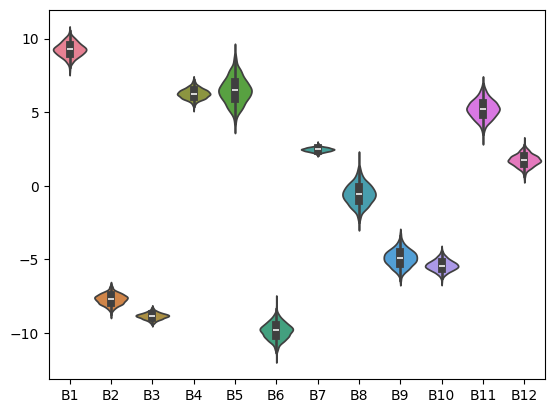

In [3]:
# Plot the distributions of the bandits
bdict = {}
for ii in range(NUM_BANDITS):
    bdict[f"B{ii+1}"] = np.random.normal(bandits[ii][0], bandits[ii][1], 1000).tolist()
df = pd.DataFrame(bdict)
sns.violinplot(data=df)

### e-Greedy Approach

Q: [9.228691706584423, -7.715146989427736, -8.835616024024246, 6.280809219279488, 6.662738972572018, -9.83137188697144, 2.4701177874734475, -0.628051390554163, -4.889705512126923, -5.380829530247886, 5.272059927188424, 1.7402427319881115]
Average Bandit: -0.46617846800550744
Maximum Bandit: 9.25950367944558


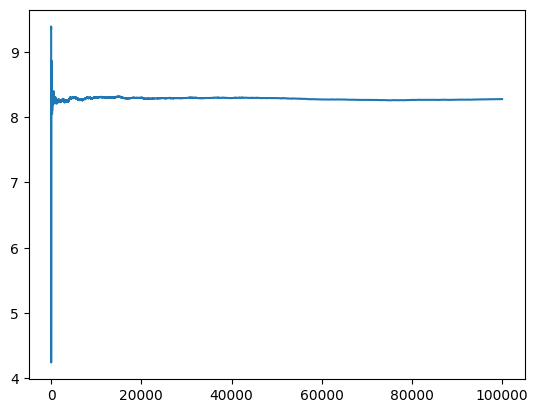

In [4]:
# Specify a State Space and constants
EPS = 0.1
STEP = 0.01
EPISODES = 100_000
statedict = {
    "A": np.array([]),
    "R": np.array([]),
    "Q": np.array(np.zeros(len(bandits)))
}

# Create a function that calculates expected rewards, Q:
def get_q(a, sdict):
    r = sdict["R"][sdict["A"]==a]
    if r.size == 0:
        return 0
    return float(np.sum(r)/r.size)

# Take Action Function
def act(sdict):

    # Take a random action
    if np.random.random() < EPS:
        a = np.random.randint(0, len(bandits))
    
    # Take the greedy action
    else:
        Q = statedict["Q"]
        a = np.argmax(Q)

    # Collect the reward for the action taken
    r = np.random.normal(bandits[a][0], bandits[a][1])

    # Update sdict and return
    sdict["A"] = np.insert(sdict["A"], sdict["A"].size, a, axis=0)
    sdict["R"] = np.insert(sdict["R"], sdict["R"].size, r, axis=0)
    sdict["Q"][a] = sdict["Q"][a] + STEP*(r - sdict["Q"][a])
    return sdict

# Run an e-greedy optimization on the bandits
average_reward = []
for e in range(EPISODES):
    statedict = act(statedict)
    average_reward.append(np.average(statedict["R"]))

# Check Average Rewards
print(f"Q: {statedict['Q'].tolist()}")
print(f"Average Bandit: {np.average([u for u, o in bandits])}")
print(f"Maximum Bandit: {np.max([u for u, o in bandits])}")
plt.plot(average_reward)

## SARSA

In [5]:
# Global Values
DISCOUNT = 0.9
EPSILON = 0.1
LEARNING_RATE = 1e-3
EPISODES = 1_000_000
ITERATIONS = 100

In [6]:
# Take an action
def take_action(env, a, s_):
    s = tuple(map(sum, zip(s_, a)))
    if s[0] < 0: s = (size-1, s[1])
    if s[0] >= size: s = (0, s[1])
    if s[1] < 0: s = (s[0], size-1)
    if s[1] >= size: s = (s[0], 0)
    r = env[s[0]][s[1]]
    return r, s

# Generate Starting Values
def learn_q(env, time_penalty=1):
    size = env.shape[0]
    A = [(0,0), (1,0), (-1,0), (0,1), (0,-1)]
    S = list(itertools.product(range(size), range(size)))
    Q = {s:{a:0 for a in A} for s in S}

    # Value Optimization
    for _ in range(EPISODES):
        a = (0, 0)
        s = (np.random.choice(size), np.random.choice(size))
        for t in range(ITERATIONS):

            # Get Actions
            actions = list(Q[s].keys())
            values = list(Q[s].values())

            # Policy
            if np.random.rand() < EPSILON:
                idx = np.random.choice(len(actions))
                a = actions[idx]
            else:
                idx = np.argmax(values)
                a = actions[idx]

            # Take Action
            s_ = s
            a_ = a
            r, s = take_action(env, a, s)
            if a==(0,0): r = r-10
            r = r - time_penalty*t
            if t==ITERATIONS-1: r = -100
            Q[s_][a_] = Q[s_][a_] + LEARNING_RATE*(r + DISCOUNT*Q[s][a] - Q[s_][a_])
    
    return Q

In [7]:
# Simulation Function
def simulate_sarsa(env, Q, starting_pos=None):

    # Initialize the plots
    fig, ax = plt.subplots()
    im = ax.imshow(env, cmap="YlGnBu", origin="upper")
    fig.colorbar(im)
    plt.cla()
    display.clear_output(wait =True)

    # Assign a Starting Position
    if starting_pos is None:
        size = env.shape[0]
        s = (np.random.choice(size), np.random.choice(size))
    else: s = starting_pos

    # Run Simultaion
    r = None
    for ii in range(ITERATIONS):

        # Plot Current State
        plt.cla()
        display.clear_output(wait =True)
        im = ax.imshow(env, cmap="YlGnBu", origin="upper")
        ax.scatter(s[1], s[0], marker="x", color="red", s=120)
        display.display(plt.gcf())
        time.sleep(0.5)
        if r==100: break

        # Get Actions
        actions = list(Q[s].keys())
        values = list(Q[s].values())

        # Policy
        idx = np.argmax(values)
        a = actions[idx]
        r, s = take_action(env, a, s)


## SARSA with One Goal

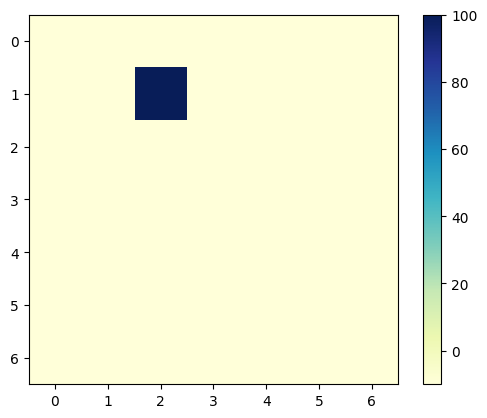

In [8]:
# Creating a State Space
size = 7
env = -10*np.ones([size, size])
goal_x = np.random.randint(size)
goal_y = np.random.randint(size)
env[goal_x][goal_y] = 100
fig, ax = plt.subplots()
im = ax.imshow(env, cmap="YlGnBu", origin="upper")
fig.colorbar(im)

In [9]:
Q = learn_q(env)

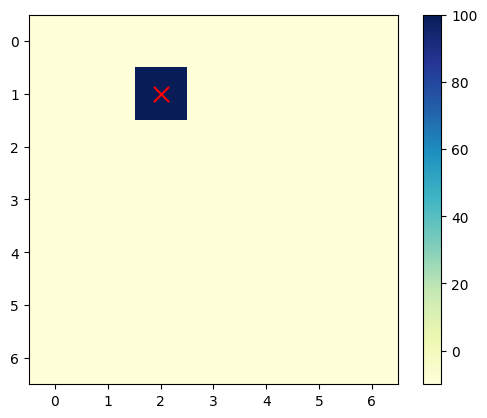

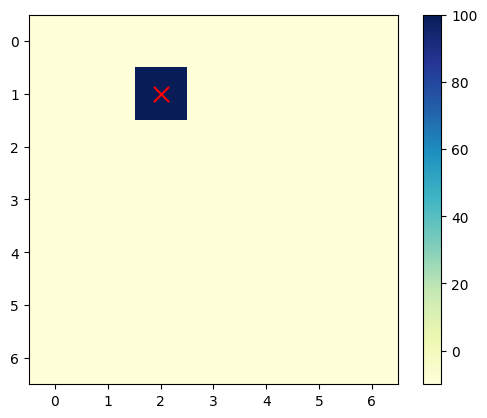

In [10]:
simulate_sarsa(env, Q)

## SARSA with Obstacles

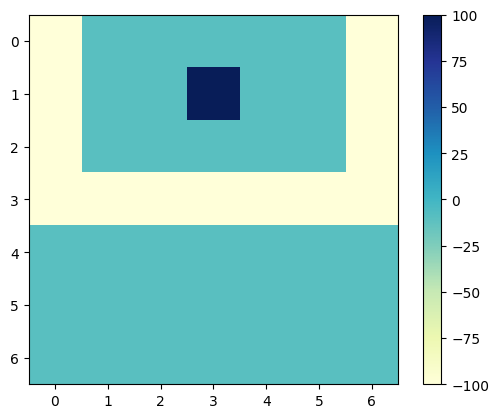

In [11]:
# Creating a State Space
size = 7
env_obs = -10*np.ones([size, size])
env_obs[1][3] = 100
for ii in range(3):
    env_obs[ii][0] = -100
    env_obs[ii][6] = -100
for jj in range(7):
    env_obs[3][jj] = -100
fig, ax = plt.subplots()
im = ax.imshow(env_obs, cmap="YlGnBu", origin="upper")
fig.colorbar(im)

In [12]:
Q_obs = learn_q(env_obs)

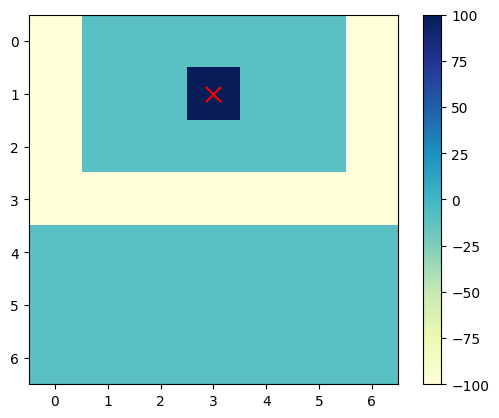

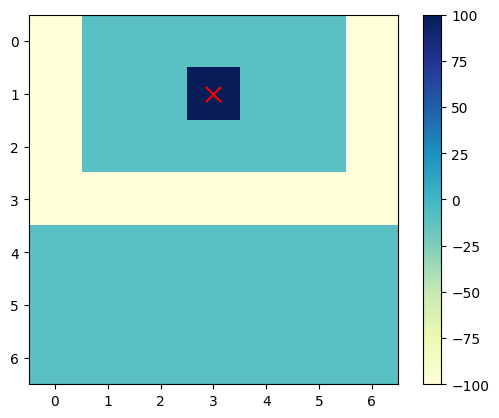

In [14]:
simulate_sarsa(env_obs, Q_obs, starting_pos=(4, 6))